In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval

%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
os.listdir('../data')

['test_case_2_var_1.csv',
 'test_case_2_var_0_01.csv',
 'test_case_2_var_0_1.csv',
 'processed_test_case_1.csv',
 'processed_test_case_2_var_0_01.csv',
 'processed_test_case_2_var_1.csv',
 'test_case_1_processed.npz',
 '_slash_cyberpod_sim_ros_slash_learning_data_throttled.csv',
 'test_case_1.csv',
 'test_case_2_var_0_001.csv']

# Reading Data

In [21]:
filename = 'test_case_2_var_1.csv'

# reading datafile
data = pd.read_csv('../data/' + filename)

# removing irrelevant entries
data = data[data['status']==2]
data = data.reset_index(drop=True)

# converting strings to arrays
data['image'] = data['image'].str.replace('[','').str.replace(']','')
data['image'] = data['image'].apply(np.fromstring, sep=', ')

data['stateVec'] = data['stateVec'].str.replace('[','').str.replace(']','')
data['stateVec'] = data['stateVec'].apply(np.fromstring, sep=', ')

# reshaping image data
data['image'] = data['image'].apply(np.reshape, newshape=(250,525,3 ))
data['image'] = data['image'].apply(lambda x: x.astype(int))

In [22]:
state_labels = ['$x$', '$y$', '$\\theta_z$', '$\\dot{x}$', '$\\dot{\\theta}_z$', '$\\theta_y$', '$\\dot{\\theta}_y$']
states = np.vstack(data['stateVec'])
images = np.stack(data['image'])
np.savez('../data/' + filename.split('.')[0] + '_processed.npz', states=states, images=images)

In [24]:
# reading datafile

data_npz = np.load('../data/' + filename.split('.')[0] + '_processed.npz')
states = data_npz['states']
images = data_npz['images']


# Plotting Data

In [25]:
class IndexTracker(object):
    def __init__(self, ax, X):
        self.ax = ax
        ax.set_title('use scroll wheel to navigate images')

        self.X = X
        self.slices = len(X)
        self.ind = 0

        self.im = ax.imshow(self.X[self.ind])
        self.update()

    def onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.ind = (self.ind - 1) % self.slices
        else:
            self.ind = (self.ind + 1) % self.slices
        self.update()

    def update(self):
        self.im.set_data(self.X[self.ind])
        self.ax.set_ylabel('slice %s' % self.ind)
        self.im.axes.figure.canvas.draw()

<IPython.core.display.Javascript object>


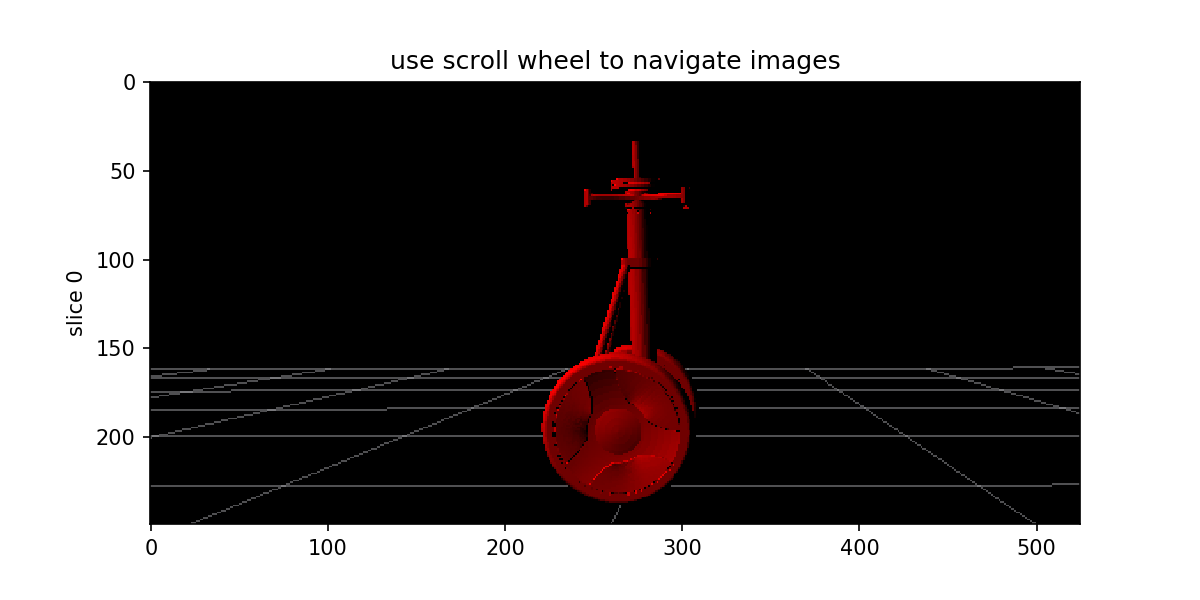

In [26]:
fig, ax = plt.subplots(1, 1, figsize=[8,4])
tracker = IndexTracker(ax, images)


fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()

<IPython.core.display.Javascript object>


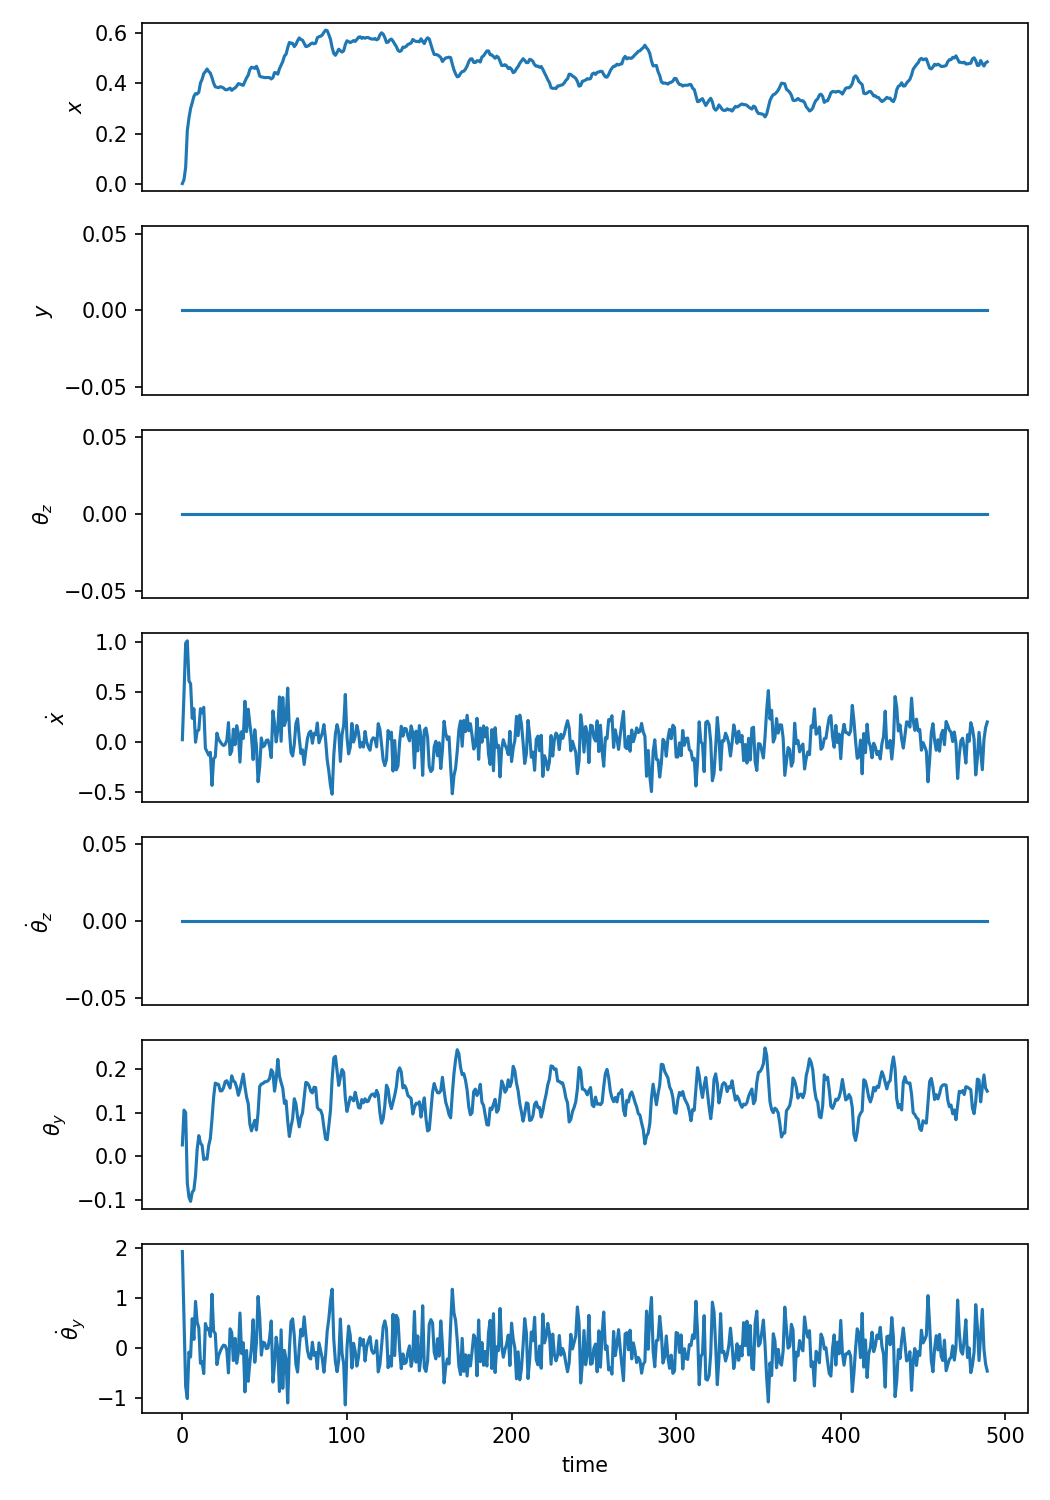

In [27]:
fig, axs = plt.subplots(len(state_labels), 1, figsize=[7,10])
for i, label in enumerate(state_labels):
    axs[i].set_ylabel(label)
    axs[i].plot(states[:,i])
    if i < len(state_labels) - 1:
        axs[i].get_xaxis().set_visible(False)
    else:
        axs[i].set_xlabel('time')
plt.tight_layout()

# Plotting Image Filters and Features

In [67]:
import skimage.feature
from skimage.color import rgb2gray
import sklearn

In [68]:
example_images = [images[1], images[150]]

<IPython.core.display.Javascript object>


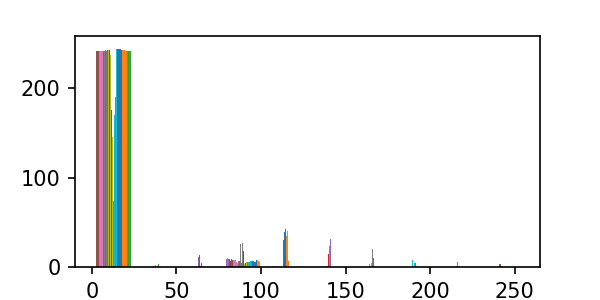

In [69]:
plt.figure(figsize=[4,2])
plt.hist(example_images[0][:,:,0]);

<IPython.core.display.Javascript object>


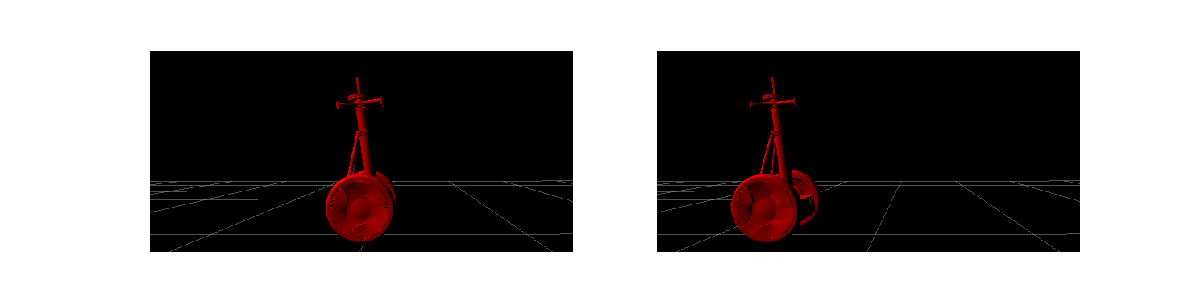

<IPython.core.display.Javascript object>


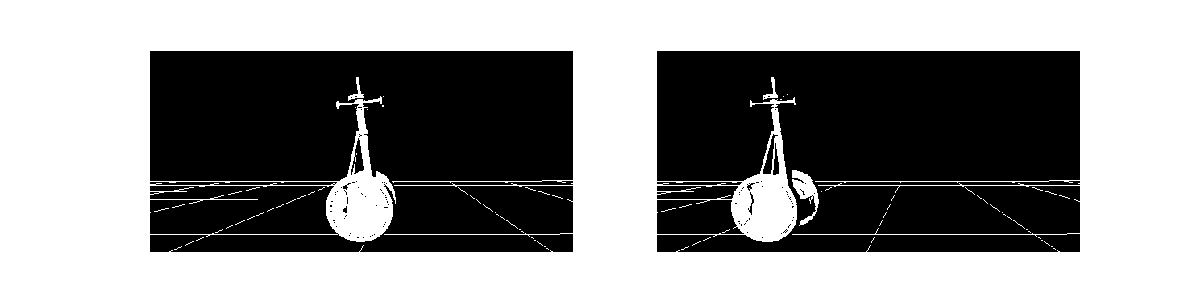

<IPython.core.display.Javascript object>


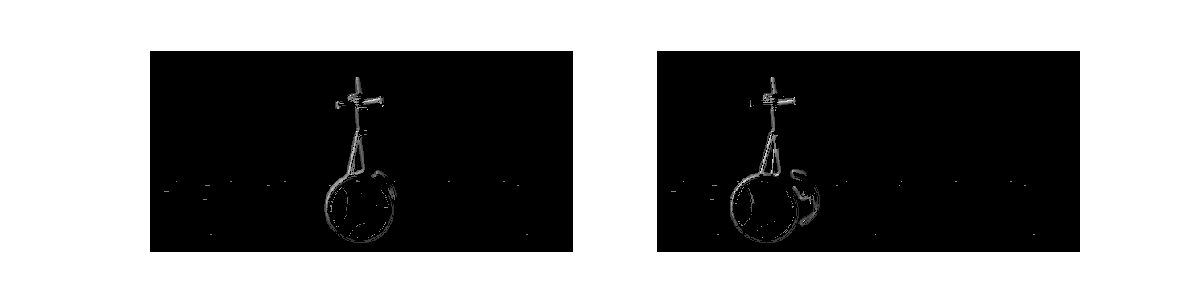

/home/sarah/anaconda3/lib/python3.7/site-packages/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


<IPython.core.display.Javascript object>


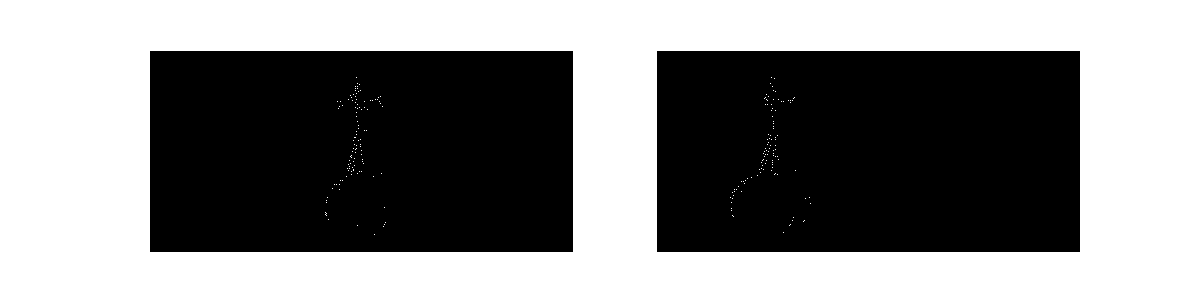

In [70]:
def plot_imgs(fn, cmap='gray'):
    plt.figure(figsize=[8,2])
    for i,img in enumerate(example_images):
        plt.subplot(1,len(example_images),i+1)
        plt.imshow(fn(img), cmap=cmap)
        plt.axis('off')
    
plot_imgs(lambda img: img, cmap=None)
# plot_imgs(lambda img: img[:,:,0])
# plot_imgs(lambda img: skimage.filters.sobel(img[:,:,0]))
plot_imgs(lambda img: skimage.filters.apply_hysteresis_threshold(img[:,:,0], low=50, high=50))
# plot_imgs(lambda img: skimage.feature.canny(img[:,:,0], low_threshold=50, high_threshold=50))
# plot_imgs(lambda img: skimage.feature.corner_fast(skimage.feature.canny(img[:,:,0], low_threshold=50, high_threshold=50), n=12, threshold=0.15))
plot_imgs(lambda img: skimage.feature.corner_fast(img[:,:,0], n=4, threshold=1e-17))
plot_imgs(lambda img: skimage.feature.corner_peaks(skimage.feature.corner_fast(img[:,:,0], 
                                                                               n=4, threshold=1.5e-17),
                                                  indices=False))


In [71]:
img = example_images[0]
detector_extractor = skimage.feature.ORB(downscale=1.01, fast_n=4, fast_threshold=2e-17, harris_k=0.2)
detector_extractor.detect_and_extract(img[:,:,0])
detector_extractor.descriptors
detector_extractor.keypoints.shape

(234, 2)

# Dataset variation differences

In [72]:
file_names = ['test_case_2_var_1.csv',
             'test_case_2_var_0_01.csv',
             'test_case_1.csv']

<IPython.core.display.Javascript object>


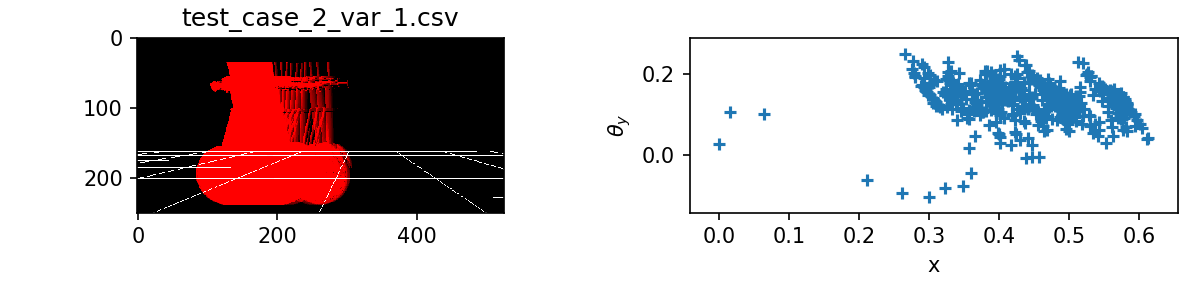

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


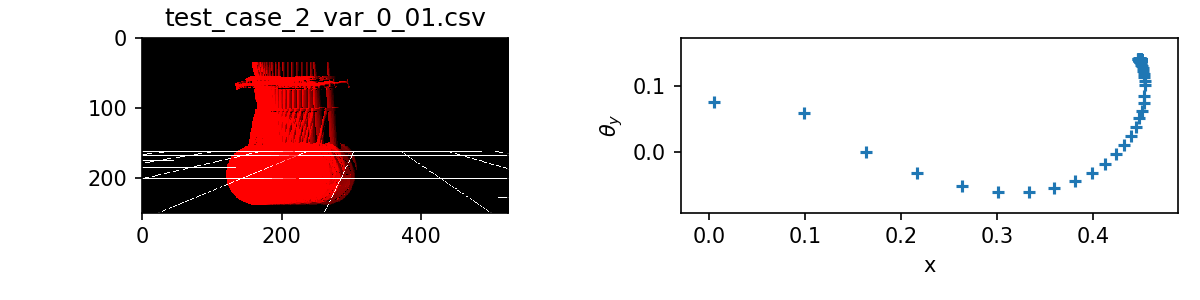

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<IPython.core.display.Javascript object>


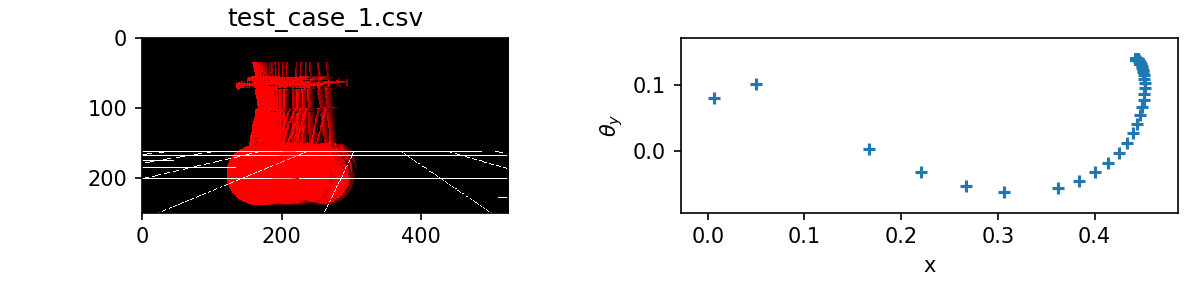

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [76]:
# reading datafile
# filename = 'test_case_1.csv'
for filename in file_names:
    data = np.load('../data/' + filename.split('.')[0] + '_processed.npz')
    states = data['states']
    images = data['images']
    plt.figure(figsize=[8,2])
    plt.subplot(1,2,1)
    plt.title(filename)
    plt.imshow(np.sum(images, axis=0))
    plt.subplot(1,2,2)
    plt.scatter(states[:,0], states[:,5], marker='+')
    plt.xlabel('x'); plt.ylabel('$\\theta_y$')
    plt.tight_layout()

# Learning

In [77]:
filename = 'test_case_2_var_1.csv'

# load data
data = np.load('../data/' + filename.split('.')[0] + '_processed.npz')
states = data['states']
images = data['images']



In [78]:
# test/train split
selected_inds = np.random.choice(len(states), size=int(len(states)*0.2), replace=False)
test_inds = np.zeros(len(states), dtype=bool)
test_inds[selected_inds] = True
train_inds = np.logical_not(test_inds)

ys = {'test': states[test_inds][:,[0,5]], 'train': states[train_inds][:,[0,5]]}
zs = {'test': images[test_inds], 'train': images[train_inds]}

In [79]:
import perception as per

In [98]:
Pred = per.FeatureRidgePredictor(ys=ys['train'], zs=zs['train'], lam=0) #, features='canny')

In [99]:
ys_pred = Pred.pred(zs['test'])

<IPython.core.display.Javascript object>


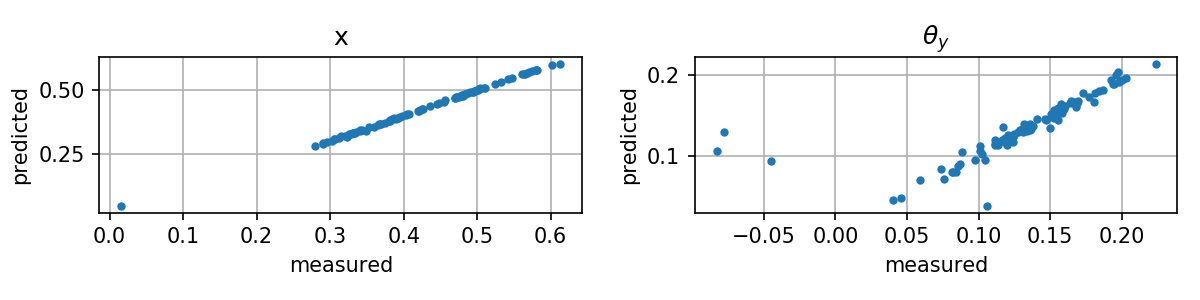

In [103]:
plt.figure(figsize=[8,2])
plt.subplot(1,2,1)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.title('x')
plt.plot(ys['test'][:,0],ys_pred[:,0], '.')
plt.grid()
plt.subplot(1,2,2)
plt.xlabel('measured')
plt.ylabel('predicted')
plt.title('$\\theta_y$')
plt.plot(ys['test'][:,1],ys_pred[:,1], '.')
plt.grid()
plt.tight_layout()

<IPython.core.display.Javascript object>


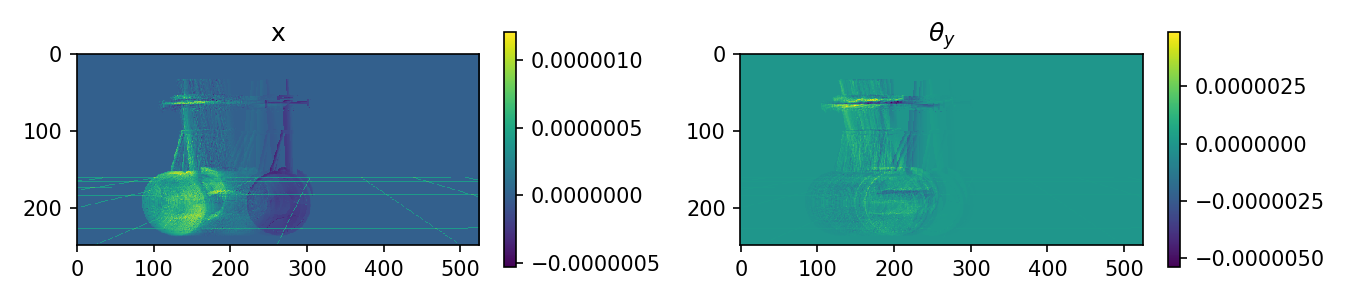

In [104]:
ahat = Pred.ahat.reshape(2, 250, -1)
plt.figure(figsize=[9,2])
plt.subplot(1,2,1)
plt.title('x')
plt.imshow(ahat[0])
plt.colorbar()
plt.subplot(1,2,2)
plt.title('$\\theta_y$')
plt.imshow(ahat[1])
plt.colorbar()
plt.tight_layout()